# Object Oriented Image Classifier

Image classification is a common problem in deep learning. In this notebook, we aim to develop a generic convolutional network which can work on multiple datasets. In addition to the model, supporting routines such as classifying user upload and finding similar images will also be developed.

## Package Import

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras import layers, models
from PIL import Image
from google.colab import files

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Image Classifier

In [3]:
def preprocess(ds, img_height, img_width, metadata, batch_size = 32, shuffle=True):
    """ a dataset wrapper that resizes images """
    # resize images as the specified height and width
    def resize_img(image, label):
        image = tf.image.resize(image, (img_height, img_width))
        image = tf.cast(image, tf.float32)
        label = tf.one_hot(label, metadata.features["label"].num_classes)
        return image, label 
    ds = ds.map(resize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # provide images as batches and enable prefetching (and shuffling)
    if shuffle:
        ds = ds.shuffle(10000, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size)
    ds = ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

Under the class of ImageClassifier, we define the convolutional neural network and and various support routines such as:
- Plotting learning curve
- Plotting confusion matrix
- Predict label
- Finding similar images



In [4]:
class ImageClassifier:
    def __init__(self, train_ds, test_ds, metadata, 
                 img_height, img_width, img_depth=3, batch_size=32, 
                 shuffle=True, augment=False, dropout=False):
        self.img_height = img_height
        self.img_width = img_width
        self.img_depth = img_depth
        self.metadata = metadata
        self.batch_size = batch_size
        # Preprocess data sources
        self.train_ds = train_ds
        self.test_ds = test_ds
        self.train_pds = preprocess(self.train_ds, img_height, img_width, 
                                    metadata, batch_size, shuffle)
        self.test_pds = preprocess(self.test_ds, img_height, img_width, 
                                   metadata, batch_size, shuffle)
        # Create and compile the model
        model = models.Sequential()
        # Standardize the data
        model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, img_depth)))
        # Data augmentation
        if augment:
            model.add(layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)))
            model.add(layers.experimental.preprocessing.RandomRotation(0.1))
            model.add(layers.experimental.preprocessing.RandomZoom(0.1))
            model.add(layers.experimental.preprocessing.RandomContrast(0.3))
            model.add(layers.experimental.preprocessing.RandomFlip())
        # Convolution and pooling to extract features
        model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
        model.add(layers.MaxPooling2D())
        model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
        model.add(layers.MaxPooling2D())
        model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
        model.add(layers.MaxPooling2D())
        # Dropout to reduce overfitting
        if dropout:
            model.add(layers.Dropout(0.2))
        # Dense layer for learning
        model.add(layers.Flatten())
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(self.metadata.features["label"].num_classes, activation='softmax'))
        # Compile the model
        model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])
        self.model = model
        self.history = None
        self.model.summary()
        
    def train(self, epochs=15):
        # fit the model       
        history = self.model.fit(self.train_pds, validation_data=self.test_pds, epochs=epochs)
        self.history = history
        self.epochs = epochs

    def plot_learning_curve(self):
        if self.history == None:
            print("Train the model first!")
            return
        # Create a figure with two subsplots
        acc = self.history.history['accuracy']
        val_acc = self.history.history['val_accuracy']
        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']
        epochs_range = range(self.epochs)
        # Accuracy
        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')
        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.show()
    
    def evaluate(self, test_ds=None):
        print("Evaluation:")
        if test_ds == None:
            test_ds = self.test_pds
        result = self.model.evaluate(test_ds)
        print(dict(zip(self.model.metrics_names, result)))

    def print_confusion_matrix(self, test_ds=None, alt_label=False):
        print("Confusion matrix:")
        if test_ds == None:
            test_ds = self.test_pds
        if alt_label == True:
            class_names = self.metadata.features["label"].alt_names
        else:
            class_names = self.metadata.features["label"].names
        # Create confusion matrix from the test dataset
        y_true = []
        for image, label in test_ds: # for each batch (batch_size, 10)
            label = tf.argmax(label, axis=1) # decode the label in a batch, return (1, batch_size)
            y_true.append(label.numpy()) # gives (num_batch, batch_size) list
        y_true = np.concatenate(y_true, axis=None) #concat and flatten
        y_pred = tf.argmax(self.model.predict(test_ds), axis=1)
        confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
        # Create a heatmap of the confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(confusion_mtx, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='g')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.show()
    
    def query(self, path, alt_label=False):
        # obtain image
        #img = tf.keras.preprocessing.image.load_img(path, target_size=(self.img_height, self.img_width))
        img = Image.open(path)
        img = img.resize((self.img_width, self.img_height))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        # obtain label
        if alt_label == True:
            class_names = self.metadata.features["label"].alt_names
        else:
            class_names = self.metadata.features["label"].names
        # make prediction on the image
        prediction = self.model.predict(tf.expand_dims(img_array, 0))
        label = tf.argmax(prediction, axis=1)
        label_as_name = class_names[int(label.numpy())]
        confidence = np.array(prediction).flatten()[label]*100
        print(f"This image most likely belongs to {label_as_name} with a {confidence:.2f} percent confidence.")
        return (img, label_as_name) # return pillow instance
    
    def find_similar(self, path, no_of_images=5, alt_label=False, 
                     search_bound=1000, tolerance=50):
        # obtain label
        if alt_label == True:
            class_names = self.metadata.features["label"].alt_names
        else:
            class_names = self.metadata.features["label"].names
        # call query() to get the image array and predicted label of the input image file
        image, label_target = self.query(path, alt_label)
        # Calculate the average color [r, g, b] of the input image
        width, height = image.size
        r = 0
        g = 0
        b = 0
        count = 0
        for i in range(width):
            for j in range(height):
                pixel = image.getpixel((i,j))
                r += pixel[0]
                g += pixel[1]
                b += pixel[2]
                count += 1
        colour_mean_target = np.array((r/count, g/count, b/count))
        # Show the image with title showing average RGB values w/o axes
        plt.imshow(image)
        plt.title(str(np.trunc(colour_mean_target)))
        plt.axis('off')
        plt.show()
        print('Similar images:')
        # Scan the original dataset for images
        n = 0
        for image, label in self.train_ds:
            im = Image.fromarray(image.numpy())
            width, height = im.size
            r = 0
            g = 0
            b = 0
            count = 0
            for i in range(width):
                for j in range(height):
                    pixel = im.getpixel((i,j))
                    r += pixel[0]
                    g += pixel[1]
                    b += pixel[2]
                    count += 1
            colour_mean = np.array((r/count, g/count, b/count))
            label_as_name = class_names[int(label.numpy())]
            # same class label and same RGB
            if label_as_name == label_target and np.allclose(colour_mean, colour_mean_target, atol=tolerance):
                plt.imshow(im)
                plt.title(str(np.trunc(colour_mean)))
                plt.axis('off')
                plt.show()
                n += 1
            if n == no_of_images:
               break
        # if not found
        if n == 0:
            print('No similar images found!')

## Client Code

The model and supporting functions can be applied to various dataset.

### Imagenette

Imagenette is a subset of 10 easily classified classes from the Imagenet dataset. We use this dataset to quickly test the capabilities of the generic network.

train: 9469
test:  3925


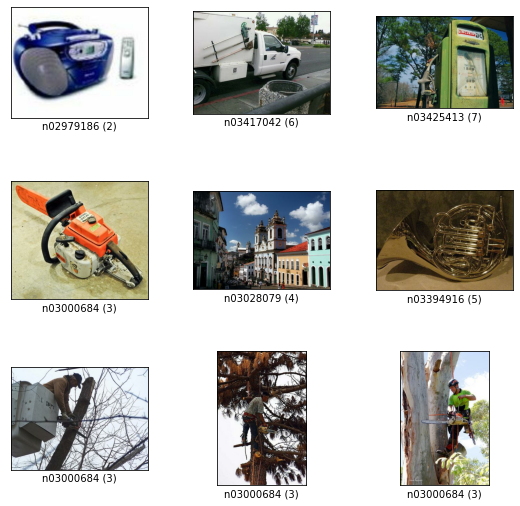

['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [ ]:
# create training and testing datasets
(train_ds, test_ds), metadata = tfds.load( 
    'imagenette/320px-v2',
    split=['train', 'validation'],
    with_info=True,
    as_supervised=True,
)
print("train:", len(train_ds))
print("test: ", len(test_ds))
fig = tfds.show_examples(train_ds, metadata)
print(metadata.features["label"].names)
# ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 
#  'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']
# add alternative names for labels
metadata.features["label"].alt_names = [
    'tench', 'English springer', 'cassette player', 'chain saw', 'church', 
    'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute'
    ]
print(train_ds)

In [ ]:
# client code for testing
IMG_SIZE = 180
imagenette = ImageClassifier(train_ds, test_ds, metadata, IMG_SIZE, IMG_SIZE, 
                             augment=False, dropout=False)
imagenette.train(epochs=15)
imagenette.plot_learning_curve()
imagenette.evaluate()
imagenette.print_confusion_matrix(alt_label=True)

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_28 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_7 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 45, 45, 64)      

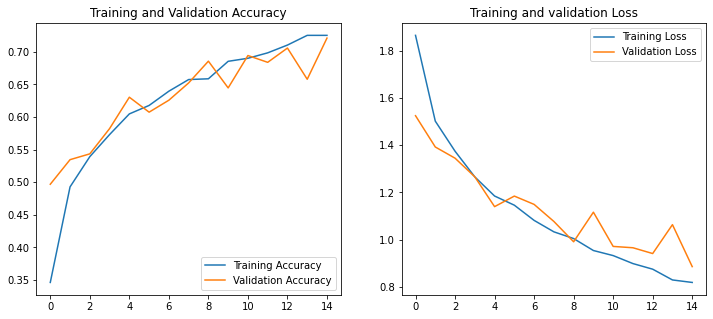

Evaluation:
123/123 [==============================] - 5s 38ms/step - loss: 0.8853 - accuracy: 0.7210
{'loss': 0.8852530121803284, 'accuracy': 0.7210190892219543}
Confusion matrix:


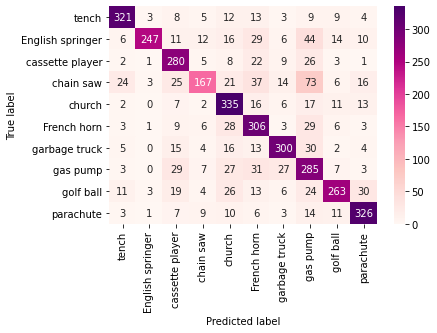

In [ ]:
# test effectiveness of data augmentation and dropout
IMG_SIZE = 180
imagenette = ImageClassifier(train_ds, test_ds, metadata, IMG_SIZE, IMG_SIZE, 
                             augment=True, dropout=True)
imagenette.train(epochs=15)
imagenette.plot_learning_curve()
imagenette.evaluate()
imagenette.print_confusion_matrix(alt_label=True)

This image most likely belongs to golf ball with a 87.16 percent confidence.
This image most likely belongs to golf ball with a 90.36 percent confidence.
This image most likely belongs to parachute with a 100.00 percent confidence.
This image most likely belongs to parachute with a 100.00 percent confidence.
This image most likely belongs to parachute with a 91.65 percent confidence.
Finding similar figures:
This image most likely belongs to golf ball with a 87.16 percent confidence.


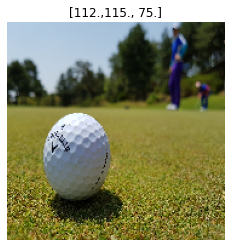

Similar images:


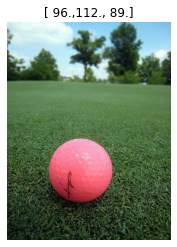

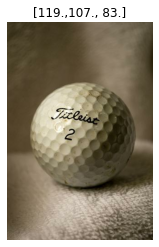

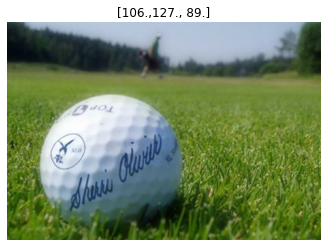

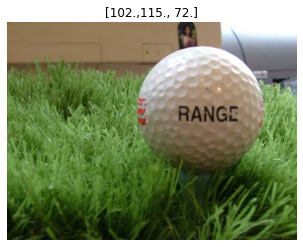

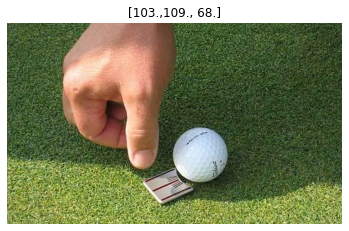

This image most likely belongs to parachute with a 100.00 percent confidence.


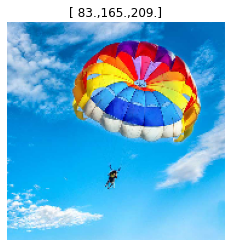

Similar images:


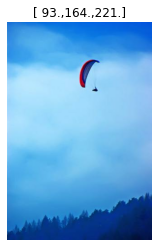

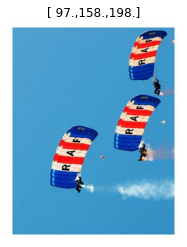

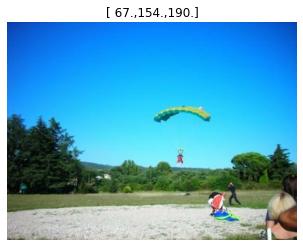

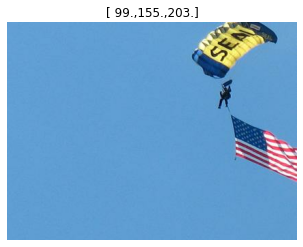

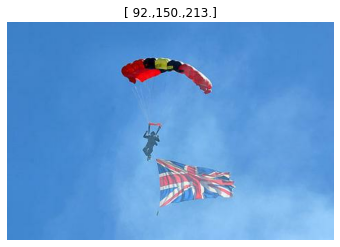

In [ ]:
# make some predictions
URL = 'https://upload.wikimedia.org/wikipedia/commons/e/ef/Golf_ball_near_green.jpg'
golf_path1 = tf.keras.utils.get_file('golfball1.jpg', origin=URL)
imagenette.query(golf_path1, alt_label=True)

URL = 'https://contents.mediadecathlon.com/p1345747/k$8bfca050583b3bfb22ace6db8769f696/bong-golf-inesis-100-x12-trang.jpg?format=auto&f=700x700'
golf_path2 = tf.keras.utils.get_file('golfball2.jpg', origin=URL)
imagenette.query(golf_path2, alt_label=True)

URL = 'https://cdn.techexplorist.com/wp-content/uploads/2018/12/parachute.jpg'
parachute_path1 = tf.keras.utils.get_file('parachute1.jpg', origin=URL)
imagenette.query(parachute_path1, alt_label=True)

URL = 'https://media.npr.org/assets/img/2018/12/21/parachute_custom-14f30a9f6c9cd40ce0c2079732f3cf6122206945-s800-c85.jpg'
parachute_path2 = tf.keras.utils.get_file('parachute2.jpg', origin=URL)
imagenette.query(parachute_path2, alt_label=True)

URL = 'https://spacenews.com/wp-content/uploads/2019/12/spacexchutes-dec19.jpg'
parachute_path3 = tf.keras.utils.get_file('parachute3.jpg', origin=URL)
imagenette.query(parachute_path3, alt_label=True)

print("Finding similar figures:")
imagenette.find_similar(golf_path1, 5, alt_label=True, tolerance=20, search_bound=2000)
imagenette.find_similar(parachute_path1, 5, alt_label=True, tolerance=20, search_bound=3000)


### Cats vs Dogs

Cats vs Dogs is a binary image classification problem which is fun to play with.

train: 11631
test:  2326


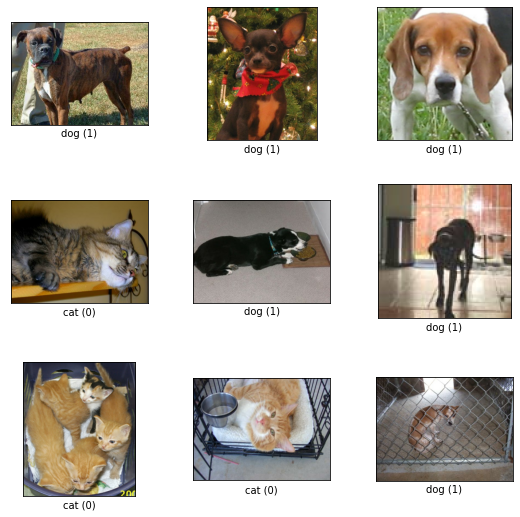

['cat', 'dog']


In [ ]:
# create training and testing datasets
(train_ds, test_ds), metadata = tfds.load( 
    'cats_vs_dogs',
    split=['train[:50%]', 'train[:10%]'],
    with_info=True,
    as_supervised=True,
)

print("train:", len(train_ds))
print("test: ", len(test_ds))
fig = tfds.show_examples(train_ds, metadata)
print(metadata.features["label"].names)

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_32 (Sequential)   (None, 150, 150, 3)       0         
_________________________________________________________________
rescaling_8 (Rescaling)      (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 37, 37, 64)      

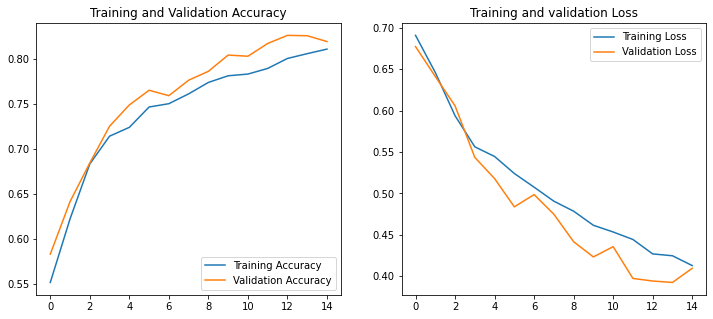

Evaluation:
73/73 [==============================] - 2s 30ms/step - loss: 0.4096 - accuracy: 0.8194
{'loss': 0.4095933139324188, 'accuracy': 0.8194324970245361}
Confusion matrix:


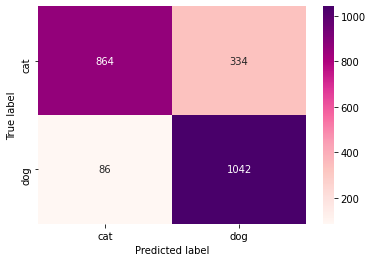

In [ ]:
# client code for testing
IMG_SIZE = 150
cats_vs_dogs = ImageClassifier(train_ds, test_ds, metadata, IMG_SIZE, IMG_SIZE, 
                               augment=True, dropout=True)
cats_vs_dogs.train(epochs=15)
cats_vs_dogs.plot_learning_curve()
cats_vs_dogs.evaluate()
cats_vs_dogs.print_confusion_matrix()

With the trained network, we can make predictions on new images, and find similar images according to their class and colour palette.

This image most likely belongs to dog with a 100.00 percent confidence.
This image most likely belongs to dog with a 87.17 percent confidence.
This image most likely belongs to dog with a 86.99 percent confidence.
This image most likely belongs to dog with a 100.00 percent confidence.


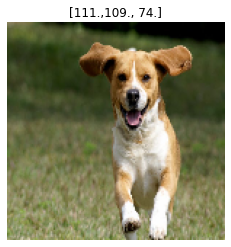

Similar images:


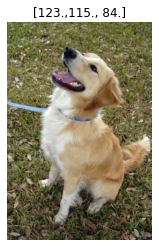

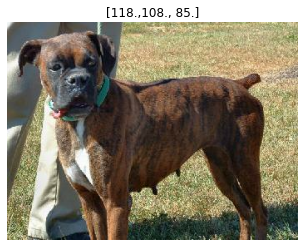

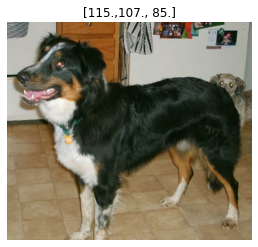

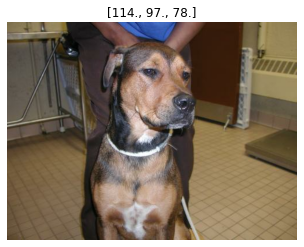

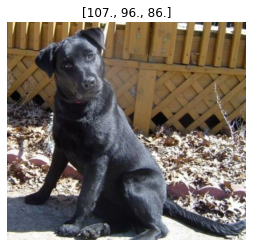

This image most likely belongs to dog with a 87.17 percent confidence.


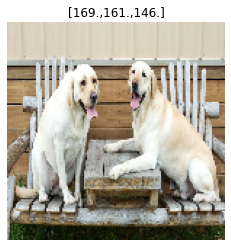

Similar images:


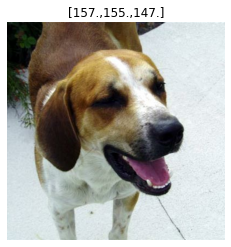

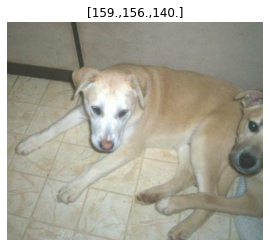

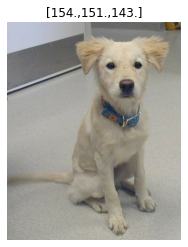

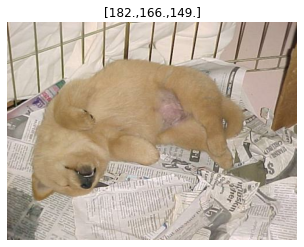

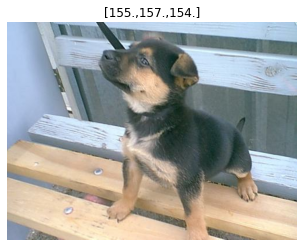

This image most likely belongs to dog with a 86.99 percent confidence.


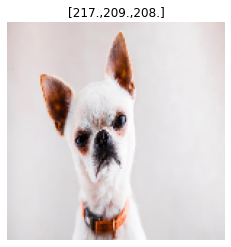

Similar images:
No similar images found!


In [ ]:
URL = 'https://i.insider.com/5484d9d1eab8ea3017b17e29?width=600&format=jpeg&auto=webp'
dog_path1 = tf.keras.utils.get_file('dog1', origin=URL)
cats_vs_dogs.query(dog_path1)

URL = 'https://www.sciencenewsforstudents.org/wp-content/uploads/2020/07/070720_bo_dogage_feat-1028x579.jpg'
dog_path2 = tf.keras.utils.get_file('dog2', origin=URL)
cats_vs_dogs.query(dog_path2)

URL = 'https://images.theconversation.com/files/319652/original/file-20200310-61148-vllmgm.jpg?ixlib=rb-1.1.0&q=45&auto=format&w=754&fit=clip'
dog_path3 = tf.keras.utils.get_file('dog3', origin=URL)
cats_vs_dogs.query(dog_path3)

cats_vs_dogs.find_similar(dog_path1, 5, tolerance=15)
cats_vs_dogs.find_similar(dog_path2, 5, tolerance=15)
cats_vs_dogs.find_similar(dog_path3, 5, tolerance=15)

### Malaria

Malaria is a disease caused by a parasite which is spread to humans through the bites of infected mosquitoes. This dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells, labelled parasitized and uninfected.

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/malaria/1.0.0.incompleteHM3ELV/malaria-train.tfrecord


  0%|          | 0/27558 [00:00<?, ? examples/s]

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.
train: 13779
test:  2756


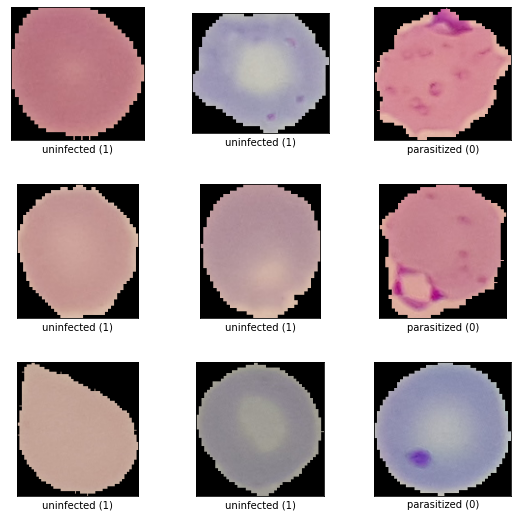

['parasitized', 'uninfected']


In [5]:
# create training and testing datasets
(train_ds, test_ds), metadata = tfds.load( 
    'malaria',
    split=['train[:50%]', 'train[:10%]'],
    with_info=True,
    as_supervised=True,
)

print("train:", len(train_ds))
print("test: ", len(test_ds))
fig = tfds.show_examples(train_ds, metadata)
print(metadata.features["label"].names)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 150, 150, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 150, 150, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 150, 150, 3)       0         
                                                                 
 random_contrast_1 (RandomCo  (None, 150, 150, 3)      0         
 ntrast)                                                         
                                                                 
 random_flip_3 (RandomFlip)  (None, 150, 150, 3)      

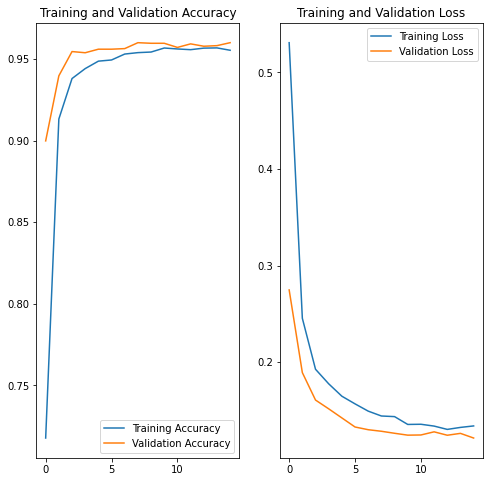

Evaluation:
87/87 [==============================] - 1s 6ms/step - loss: 0.1214 - accuracy: 0.9601
{'loss': 0.12139755487442017, 'accuracy': 0.9600870609283447}
Confusion matrix:


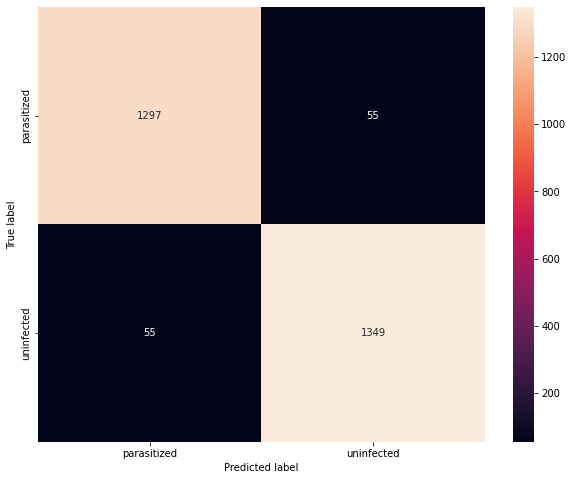

In [9]:
IMG_SIZE = 150
malaria = ImageClassifier(train_ds, test_ds, metadata, IMG_SIZE, IMG_SIZE, 
                               augment=True, dropout=True)
malaria.train(epochs=15)
malaria.plot_learning_curve()
malaria.evaluate()
malaria.print_confusion_matrix()